---
layout: code-post
title: Training neural nets - Backpropagation
tags: [neural nets]
---

Following our foray into the expressive power of shallow neural
networks, let's train a shallow neural network instead of 
designing them by hand.


Outline:

0. Generating data
1. Backpropagation
2. Examples

## 0. Generating Data

Before we really get going, I'm going to set up some training data. For
this notebook, I'm going to uniformly generate points in a 10 x 10 square
with the bottom left corner at the origin. The points will be classified
by where the fall with respect to input functions. We'll mostly be using
linear functions to carve up our test space, so we'll create some helper
functions for those as well.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import logging

In [2]:
# Functions for lines
class SlopeLine():
    """ a line defined by slope and intercept """
    def __init__(self, m, b):
        self.m = m
        self.b = b
        
    def y(self, x):
        return self.m * x + self.b
    
    def x(self, y):
        return (y - self.b) / self.m

def get_slope_line(point_1, point_2):
    """returns slope line object with line determined by the points
    where point_i = (x, y)"""
    
    m = (point_2[1] - point_1[1]) / (point_2[0] - point_1[0])
    b = point_1[1] - m * point_1[0]
    
    return SlopeLine(m, b)

# Functions to generate points
class Inequality():
    """
    given a function f(x) of one variable.
    we will test y < f(x) or y > f(x)
    for a point (x, y)
    """
    def __init__(self, func, ineq_type):
        self.func = func
        
        if ineq_type == '<':
            self.eval = self.less_than
        elif ineq_type == '>':
            self.eval = self.greater_than
        else:
            raise Exception("ineq_type must be '>' or '<'")
        
    def less_than(self, point):
        return point[:,1] < self.func(point[:,0])
    
    def greater_than(self, point):
        return point[:,1] > self.func(point[:,0])
    

def generate_points(n, inequality_lists, random_seed=47):
    """ get n points in the 10x10 square classified by
    inequalities.
    
    inequality_lists should be a list of lists of inequalities.
    
    Points are evaluated to the positive class (1) by the
    interior lists if all the inequalities in that list
    are satisfied. Then, if any of the the interior lists
    return true, the point is classified as true.
    
    """
    np.random.seed(random_seed)
    
    data_x = np.random.uniform(0, 10, (n, 2))
    
    def evaluate_list(inequality_list):
        
        evals = np.array([ineq.eval(data_x) for ineq in inequality_list]) \
                  .transpose()
        return np.array([all(p) for p in evals])
    
    all_evals = np.array([evaluate_list(il) for il in inequality_lists]) \
                  .transpose()
    
    data_y = np.array([1 if any(p) else -1 for p in all_evals])
    
    data = {
        'x_1': data_x[:,0]
        ,'x_2': data_x[:,1]
        ,'y': data_y
    }
    return pd.DataFrame(data)

## 1. Backpropagation

Even though neural networks are not an example of convex optimization,
it has still proven useful to train the networks via stochastic gradient
descent (SGD). Even if the found minima are only local or not even
minima, this does not preclude their usefulness.

Let $f(x, W)$ be the output of the neural net with weights $W$ at
the input $x$. Previously, we had normalized the output by using the
sign function to map to $\pm1$. In this case we will not do this, leaving
the output layer to have the identity function as its activation function.
Since the desired values are $\pm1$, we will stick with the hinge loss,
which is defined as $\ell(x, y, W) = \max\{0, 1 - y f(x, W)\}$. As before,
if $1 - y f(x, W) \leq 0$, i.e., if the correct sign is being predicted,
then the hinge loss has the zero vetor as a subgradient (with respect to
$W$). Otherwise a subgradient is $- y\partial_W f(x, W)$. Thus in the 
update step we have to calculate the gradient of the neural network with
respect to the weights.

The backpropagation algorithm is used to calculate this gradient. As noted in 
the [activation functions](https://kevinnowland.com/code/2020/04/19/activation-functions.html)
post, feed forward neural networks are compositions of affine linear 
transformations (of which the weights are parameters) and component-wise 
activation functions. The structure of the composition suggests the
backpropagation algorithm, where derivatives with respect to the weights
in layers closer to the output layer can be used to calculate the
derivatives with respect to weights closer to the input layer.
The backpropagation algorithm actually consists of two parts, a forward
pass through the neural network to calculate inputs and outputs of
each layer and the backward pass to calculate the components of the
gradient.

The typical scheme is to divide the training set into roughly equally
sized _batches_. Once every sample in the training set has been seen
once, that is the end of the first _epoch_. The batch size and the
number of epochs are hyperparameters to tune alongside the learning
rate.

I'm going to upgrade the `SimpleNN` class I used previously to work in
layers. The first step that I'll do is to create a `Neuron` class
and then a `Layer` class that takes will use the `Nuerons`.

In [3]:
class Neuron():
    """ a neuron with an activation function and its derivative """
    def __init__(self, sigma, sigma_prime):
        self._sigma = sigma
        self._sigma_prime = sigma_prime
        
    @property
    def sigma(self):
        return self._sigma
    
    @property
    def sigma_prime(self):
        return self._sigma_prime
        
    def __str__(self):
        return "Neuron()"
    
class Layer():
    """ a layer of a neural network. The layer assumes that
    every neuron has the same activation function except
    for potentially a constant neuron at the end. If
    being used as an input layer, sigma_prime can be
    left as None. If has_const==True, then the nth
    neuron will be the constant neuron"""
    
    def __init__(self, n, sigma, sigma_prime=None, has_const=False):
        self._neurons = [Neuron(sigma, sigma_prime) for i in range(n)]
        self._has_const = has_const
        
        if has_const:
            self._neurons[-1] = Neuron(const, const_prime)
        
    def __str__(self):
        return "Layer() of {} neurons".format(self.width)
    
    def __repr__(self):
        return self.__str__()
    
    @property
    def neurons(self):
        return self._neurons
    
    @property
    def has_const(self):
        return self._has_const
    
    @property
    def width(self):
        return len(self._neurons)
        
    def output(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma(x[i]) for i in range(len(x))])
    
    def output_prime(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma_prime(x[i]) for i in range(len(x))])
        

The next block of code for the `NeuralNet` class is significantly larger.
The input to the class is a list of `Layer`s. One large improvement over
the `SimpleNeuralNet` is that the weights between layers are automatically
sized and initialized. The Kaiming He initializaiton is used, which is
what is typically used for ReLU activators, but the weights can also be
set by hand.

The bulk of the code is for the forward pass, the backward pass, and the
`fit()` function, which is where stochastic gradient descent with
backpropagation is used. We did not give flexibility in terms of the loss
function, and currently the hinge loss, as explained above, is hard-coded
in.

In [16]:
class NeuralNet():
    """ a neural net that is constructed from the layers
    it is given. Should be given both an input layer 
    and an output layer. Weights will be initialized
    with the proper shape, but as all ones and zeros. They
    can either be initiated using the function included
    here or set by hand.
    
    With T hidden layers, we have T+2 layers of neurons
    as we have the input and output layers. There are only
    T+1 layers of weights, however, as there are no
    weights from the output layer.
    
    We're going to initialize with Kaiming initializaiton.
    If non-ReLU / ELU is used, set w by hand before training."""
    
    def __init__(self, layer_list, check_w_before_set=True, random_seed=None):
        np.random.seed(random_seed)
        
        self._layers = layer_list
        self._checks = check_w_before_set
        
        def get_layer_architecture(l, l_next):
            arch = np.ones(shape=(l_next.width, l.width))
            if l_next.has_const:
                arch[-1,:] = 0
            return arch
            
        self._architecture = [
            get_layer_architecture(self._layers[i], self._layers[i+1])
            for i in range(len(self._layers) - 1)
        ]
        
        self._w = [
            np.random.normal(0, np.sqrt(2.0 / a.shape[1]), size=a.shape) * a
            for a in self._architecture
        ]
        
    def __str__(self):
        num_hidden = len(self._layers) - 2
        width = np.max([l.width for l in self._layers])
        return "NeuralNet() with {0} hidden layer(s) and width {1}".format(num_hidden, width)
        
    @property
    def layers(self):
        return self._layers
    
    @property
    def architecture(self):
        return self._architecture
        
    @property
    def w(self):
        return self._w
    
    @property
    def check_w_before_set(self):
        return self._checks
    
    def _check_architecture(self, w, a):
        """checks that w has zeros wherever a does """
        inds = np.where(a==0)
        if len(inds[0]) == 0:
            return True
        else:
            return all([w[inds[0][i], inds[1][i]] == 0 for i in range(len(inds[0]))])
    
    @w.setter
    def w(self, w_val):
        if self._checks:
            # check that w_val has proper sizes
            assert len(w_val) == len(self._w), "proposed w has bad length"
            assert all([w_val[i].shape == self._w[i].shape for i in range(len(self._w))]), \
                "proposed w has bad shapes somewhere"
            assert all([self._check_architecture(w_val[i], self._architecture[i]) for i in range(len(self._w))]), \
                "proposed w has bad architecture"
        self._w = w_val
        
    def copy_weights(self):
        return [w.copy() for w in self._w]
        
    def _clean_x(self, x):
        """ take data of form (n_samples, n_features)
        that is either a pandas DataFrame, list, or numpy array
        and add a row of 1s then convert to a numpy array and
        transpose. """
        if type(x) == np.ndarray:
            # check if it's already clean
            if x.shape[0] == self._layers[0].width:
                if (x[-1,:] == 1).all():
                    return x
            else:
                return np.append(x, np.ones((x.shape[0], 1)), axis=1).transpose()
        elif type(x) == pd.DataFrame:
            xx = x.copy()
            xx['const'] = 1
            return xx.values.transpose()
        elif type(x) == list:
            return np.array([row + [1] for row in x]).transpose()
    
    def _clean_y(self, y):
        """ take a column vector and make sure it's a numpy column vector """
        if type(y) == np.ndarray:
            return y.reshape(-1, 1)
        elif type(y) == pd.Series:
            return y.values.reshape(-1, 1)
        elif type(y) == list:
            return np.array(y).reshape(-1, 1)
        
        
    def raw_output(self, x):
        """ gets the raw output of the neural network
        
        x needs to have shape (n_samples, n_features)
        without the constant feature appended."""
        
        raw_output, _, _ = self._forward_pass(self._clean_x(x))
        
        return raw_output
    
    def predict(self, x):
        """ gets the -1 or +1 prediction of the neural network """
        return sign(self.raw_output(x))
    
    def _forward_pass(self, x):
        """ forward pass through the neural network recording
        the outputs and inputs as we go. As an internal
        function, the input x will already be an numpy array
        with shape (n_features+1, n_smples). The +1 is
        for the constant feature."""
        
        # every layer has an input
        a = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
                
        # every layer has an output
        o = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
        
        a[0] = x
        o[0] = self._layers[0].output(a[0])
        
        for i in range(1, len(self._layers)):
            a[i] = np.matmul(self._w[i-1], o[i-1])
            o[i] = self._layers[i].output(a[i])
        
        raw_output = o[-1].transpose()
        
        return raw_output, a, o
    
    def _backward_pass(self, a, o, y):
        """ backward pass through the neural network
        using the forward pass results to calculate the gradient
        as well as the true values which in this case
        are +1 or -1 only. y should be a row vector of
        these values with the same number of columns
        as a[-1] and o[-1], which should have indenticial shapes.
        
        The output is the average gradient for the samples given."""
        
        num_samples = y.shape[1]
        
        # first calculate the sigma_prime values for each hidden + output layer
        sigma_prime = [None] + \
            [self._layers[i].output_prime(a[i]) for i in range(1, len(self._layers))]
        
        # now we start the backward pass for real
        delta = [None] + [np.zeros(a[i].shape) for i in range(1, len(self._layers))]
        z = o[-1] - y
        delta[-1] = z
        
        for i in range(-2, -len(delta)-1, -1):
            # this is w[i+1] bc len(w) = len(delta) - 1
            delta[i] = np.matmul(self._w[i+1].transpose(), (sigma_prime[i+1]) * delta[i+1])
        
        # calculate the average gradient across all samples
        return [
            np.matmul((sigma_prime[i+1] * delta[i+1]), o[i].transpose()) / num_samples
            for i in range(len(self._w))
        ]
    
    def fit(self, x, y, eta=0.1, max_error=0.1, 
            max_epochs=5, batch_size=100, max_iter=None,
            save_data=False, random_seed=None):
        """ use stochastic gradient descent with backpropagation
        to fit the network to the given training data x which
        should be of size (n_samples, n_features),
        y should be of size (n_samples, 1)"""
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        x_ = self._clean_x(x) # (n_features + 1, n_samples) matrix
        y_ = self._clean_y(y) # column vector
        num_samples = y_.shape[0]
        
        # some samples might be left behind
        batches_per_epoch = np.floor(num_samples / batch_size)
        saved_data = []
        
        w = self.copy_weights()
        
        def calculate_train_error():
            current_predictions = self.predict(x_)
            wrong = np.sum(y_ * current_predictions < 0)
            return 1.0 * wrong / num_samples
                    
        curr_iter = 1
        curr_epoch = 1
        curr_batch_number = 0
        batch_indexes = np.arange(num_samples)
        train_error = calculate_train_error()
        
        def get_save_data():
            max_w = np.max([np.max(np.abs(w)) for w in self._w])
            min_w = np.min([np.min(np.abs(w)) for w in self._w])
            current_output = self.raw_output(x_)
            z = 1 - current_output * y_
            avg_loss = np.mean(z * (z>0))

            return {
                'epoch': curr_epoch
                ,'avg_loss': avg_loss
                ,'train_error': train_error
                ,'max_w': max_w
                ,'min_w': min_w
                ,'w': self.copy_weights()
            }
            
        
        if save_data:
            saved_data = [get_save_data()]  
            
        keep_training = True   
        while keep_training:
            
            if curr_batch_number == 0:
                # re-shuffle indexes as neded
                logging.debug("NeuralNet.fit(): starting epoch {}".format(curr_epoch))
                np.random.shuffle(batch_indexes)
                
            batch_ind = batch_indexes[curr_batch_number * batch_size:(curr_batch_number + 1) * batch_size]
            
            x_batch = x_[:, batch_ind]
            y_batch = y_[batch_ind,:]
            
            # forward pass
            _, a, o = self._forward_pass(x_batch)
            
            # backward pass
            grad = self._backward_pass(a, o, y_batch.transpose())
            
            w = [w[i] - eta * grad[i] for i in range(len(w))]
            self.w = [
                (curr_iter * self._w[i] + w[i]) / (curr_iter + 1)
                for i in range(len(self._w))
            ]
            
            train_error = calculate_train_error()
            curr_iter += 1
            curr_batch_number = int((curr_batch_number + 1) % batches_per_epoch)
            
            if curr_batch_number == 0:
                curr_epoch += 1
                
                if save_data:
                    saved_data += [get_save_data()]
                    
            keep_training = train_error >= max_error and curr_epoch <= max_epochs
            if max_iter is not None:
                keep_training = keep_training and curr_iter <= max_iter
            
            
        if curr_epoch > max_epochs:
            logging.warning("NeuralNet.fit():no convergence, train_error above max_error")
        else:
            logging.warning("NeuralNet.fit(): converged during epoch {}.".format(curr_epoch-1))
        
        if save_data:
            return saved_data
        else:
            return None
        

Now that we have that implemented, let's code up some activation
functions that we might want to play with in the
future.. We will probably stick
with the ReLU functions, but maybe we'll get ambitious. 

In [17]:
# here are some activation functions and derivatives we might use
def const(x):
    if type(x) == np.ndarray:
        return np.ones(x.shape)
    elif type(x) == list:
        return np.ones(len(x))
    else:
        return 1
    
def const_prime(x):
    if type(x) == np.ndarray:
        return np.zeros(x.shape)
    elif type(x) == list:
        return np.zeros(len(x))
    else:
        return 0

def relu(x):
    return x * (x>0) + 0 * (x<=0)

def relu_prime(x):
    return 1 * (x>0) + 0 * (x<=0)

def sign(x):
    return 1 * (x > 0) + -1 * (x <= 0)

## 2. Training

Now that we're set up, let's get training on some data.

### Setup Training Data

Now let's setup the training data that we want the neural net to learn.
We'll go simple by having two lines, $x_2=-x_1 + 10$ and $x_2=x_1$ and the positive
class will be below both of these lines. All of our data will be in the square
$[0, 10]\times[0, 10]$, such that the positive class forms a triangle of base 10
and height 5.

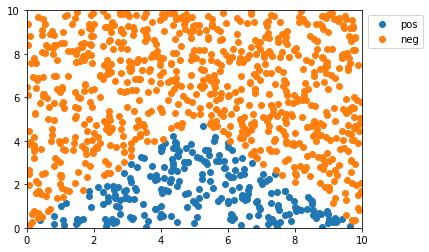

In [18]:
lines = [SlopeLine(1, 0), SlopeLine(-1, 10)]
ineqs = [Inequality(lines[0].y, '<'), Inequality(lines[1].y, '<')]
train_data = generate_points(1000, [ineqs])

fig, ax = plt.subplots(1, 1)
lims = np.array([0, 10])

ax.set_xlim(lims)
ax.set_ylim(lims)

c_tr = train_data['y'] == 1
ax.plot(train_data[c_tr]['x_1'], train_data[c_tr]['x_2'], 'o', label='pos')
ax.plot(train_data[~c_tr]['x_1'], train_data[~c_tr]['x_2'], 'o', label='neg')
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))

plt.show()

Note that this means that if every prediction is positive, the training
error is ~75% whereas if every prediction is negative than the trianing
error is ~25%. Any error significantly under 25% is good.

### Training attempt no. 1 - random initialization

Now, let's try training a neural network. We know from the 
[activation functions](https://kevinnowland.com/code/2020/04/19/activation-functions.html)
post that we only need one-hidden layer of width 2 using ReLU activation functions in order
to learn this shape, so let's not give ourselves any more freedom than is
required. At least initially.

You may see that "no. 1" up there and think that something might go wrong. 
Have some faith! We're going to set `save_data=True` so that we can analyze 
what happens after each epoch. You know, just in case this doesn't work out.

In [19]:
input_layer = Layer(3, lambda x: x, None, True)
hidden_layer = Layer(2, relu, relu_prime, False)
output_layer = Layer(1, lambda x: x, const, False)

nn_1 = NeuralNet([input_layer, hidden_layer, output_layer], random_seed=12)

data = nn_1.fit(train_data[['x_1', 'x_2']], train_data['y'],
              eta=.001,
              max_error=0.1,
              max_epochs=100,
              batch_size=100,
              save_data=True,
              random_seed=6)

So with 100 epochs, the training error stayed above the specified maximum error of 10%.
Let's plot what the initial and final predictions would have been as well as the
evolution of the loss and error over time.

minimum training error: 0.185


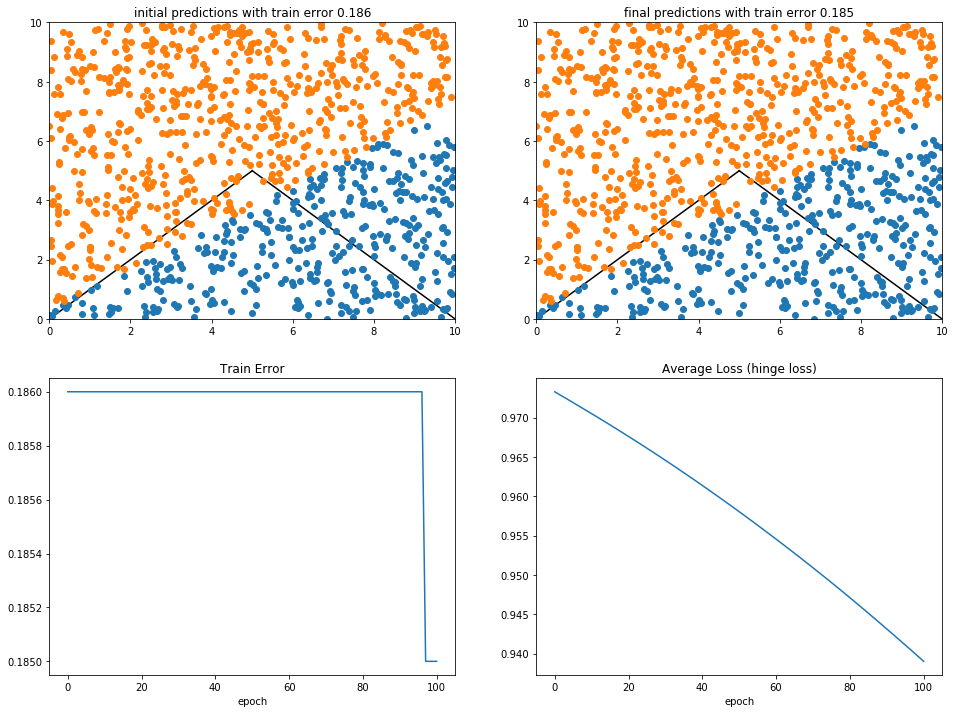

In [20]:
def plot_training_info(train_data, fit_data, nn):
    
    predictions = train_data[['x_1', 'x_2', 'y']].copy()
    predictions['final'] = nn.predict(train_data[['x_1', 'x_2']])
    nn.w = fit_data[0]['w']
    predictions['initial'] = nn.predict(train_data[['x_1', 'x_2']])
    nn.w = fit_data[-1]['w'] # restore the current trained state
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    ax[0, 0].set_xlim([0, 10])
    ax[0, 0].set_ylim([0, 10])
    ax[0, 1].set_xlim([0, 10])
    ax[0, 1].set_ylim([0, 10])
    
    ax[0, 0].plot([0, 5], [0, 5], color="black")
    ax[0, 0].plot([5, 10], [5, 0], color="black")
    ax[0, 1].plot([0, 5], [0, 5], color="black")
    ax[0, 1].plot([5, 10], [5, 0], color="black")

    c = predictions['initial'] == 1
    ax[0, 0].plot(predictions[c]['x_1'], predictions[c]['x_2'], 'o', label='pos')
    ax[0, 0].plot(predictions[~c]['x_1'], predictions[~c]['x_2'], 'o', label='neg')
    ax[0, 0].set_title('initial predictions with train error {}'.format(data[0]['train_error']))

    c = predictions['final'] == 1
    ax[0, 1].plot(predictions[c]['x_1'], predictions[c]['x_2'], 'o', label='pos')
    ax[0, 1].plot(predictions[~c]['x_1'], predictions[~c]['x_2'], 'o', label='neg')
    ax[0, 1].set_title('final predictions with train error {}'.format(data[-1]['train_error']))

    ax[1, 0].plot([d['train_error'] for d in data])
    ax[1, 0].set_title('Train Error')
    ax[1, 0].set_xlabel('epoch')

    ax[1, 1].plot([d['avg_loss'] for d in data])
    ax[1, 1].set_title('Average Loss (hinge loss)')
    ax[1, 1].set_xlabel('epoch')   
    
    return fig, ax

fig, ax = plot_training_info(train_data, data, nn_1)

print("minimum training error:", min([d['train_error'] for d in data]))
plt.show()

The training error very quickly gets fixed as every point is predicted to be
negative, but the hinge loss actually keeps decreasing. This suggests
that the hinge-loss, which is what the stochastic gradient descent procedure is
actually trying to minimize, might not be the correct loss function.

Examining the weights, we can see that initially the weights in $W^1$
from the hidden layer to the output layer have different signs. The ReLU
activations will only ever put out non-negative values, so this is a
requirement for the shallow neural network to predict both positive
and negative values.

In [21]:
print(data[0]['w'][1])

[[ 0.00512708 -0.12022767]]


However, as soon as the third epoch, both of these weights are negative,
and the neural network will now only predict negative values. this remains true
for every epoch afterwards as well.

In [22]:
print(data[3]['w'][1])

[[ 0.00630005 -0.12259217]]


### Training attempt no. 2 - explosion!

For the second attempt, let's increase the learning parameter `eta` and see
what happens if we start making bigger jumps.

In [23]:
np.seterr('raise')

nn_2 = NeuralNet([input_layer, hidden_layer, output_layer], random_seed=12)

data = nn_2.fit(train_data[['x_1', 'x_2']], train_data['y'],
              eta=.01,
              max_error=0.1,
              max_epochs=100,
              batch_size=100,
              save_data=True,
              random_seed=6)

Well this is pretty easy to interpret. What ends up happening is that
we are running into the _exploding gradients_ problem that is caused by
the recursive nature of the backpropagation algorithm. Since our fit
algorithm updates the neural network in place as it goes (sorry all you
functional programmers out there, it hurts me a bit too), we can
examine the weights at the moment that things exploded. Let's print
out the largest absolute value of any of the weights:

In [24]:
print(np.max([np.max(np.abs(w)) for w in nn_2.w]))

1.2065271892231824


Ways to prevent this that I have come across include putting in a simple maximum
weight value or being more careful with the value of `eta` that is used.
I'm not going to do either of these in this notebook.

### Training attempt no. 3 - start smarter

For the third training attempt, I'm going to start the neural network
from an advantageous position by fixing the weights. As discussed above,
we need the weights in $W^1$ to have different signs, so we'll initialize them
to be $+1$ and $-1$. With that done, our work in the activation functions
post informs us that if the initial weights in $W^0$ did nothing to
transfrom the inputs, that the predicted output would be positive in
the fourth quadrant as well as below the line $x_2=x_1$ in the 
first quadrant and negative elswhere. We can in fact design 
an affine linear transformation $W^0$ by hand that collapses
the vector $(1, 1)$ onto the $x_1$-axis and then rotates the
picture by $-\pi/4$ degrees to make the shape point that we
want. We can then shift the point into the 
$[0, 10]\times[0, 10]$ box where are points lie. Working
all that out, one might initialize the neural net as
follows:

In [25]:
input_layer = Layer(3, lambda x: x, None, True)
hidden_layer = Layer(2, relu, relu_prime, False)
output_layer = Layer(1, lambda x: x, const, False)

nn_3 = NeuralNet([input_layer, hidden_layer, output_layer])

initial_weights = [
    np.array([[1, -1, 1], [2, 0, -15]])
    ,np.array([[1, -1]])
]
nn_3.w = initial_weights

data = nn_3.fit(train_data[['x_1', 'x_2']], train_data['y'],
              eta=.0005,
              max_error=0.1,
              max_epochs=100,
              batch_size=100,
              save_data=True,
              random_seed=6)

Hey hey, we got down below the threshold! Let's take a look at
what the initial predictions would have been and the final
step predictions.

minimum training error: 0.1


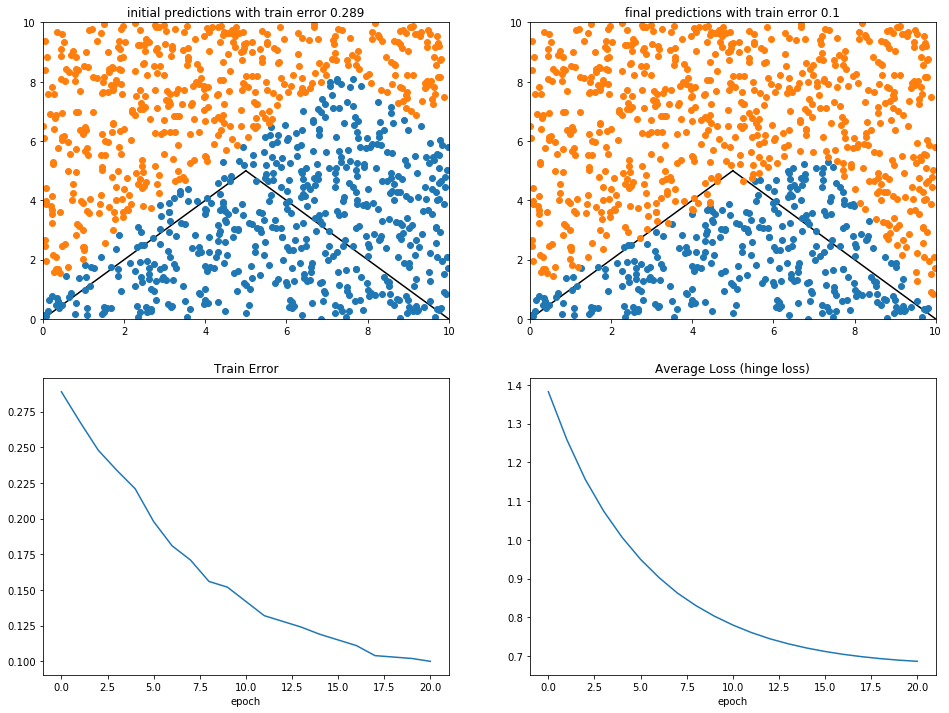

In [26]:
fig, ax = plot_training_info(train_data, data, nn_3)
print("minimum training error:", min([d['train_error'] for d in data]))
plt.show()

Looks like the triangle of positivity shifted more closely into position!
However, the good results here are also the result of choosing an `eta` value
that worked as well as a good number of epochs. This result is not robust.
We can recreate an exploding gradient error by setting `max_error` to be
`0.05` and increasing `max_epochs` to 200.

### Training attempt no. 4 - train more

Now let's lower the `max_error` and see what happens as training continues.

In [27]:
nn_4 = NeuralNet([input_layer, hidden_layer, output_layer])

initial_weights = [
    np.array([[1, -1, 1], [2, 0, -15]])
    ,np.array([[1, -1]])
]
nn_4.w = initial_weights

data = nn_4.fit(train_data[['x_1', 'x_2']], train_data['y'],
              eta=.001,
              max_error=0.05,
              max_epochs=100,
              batch_size=100,
              save_data=True,
              random_seed=6)

minimum training error: 0.086


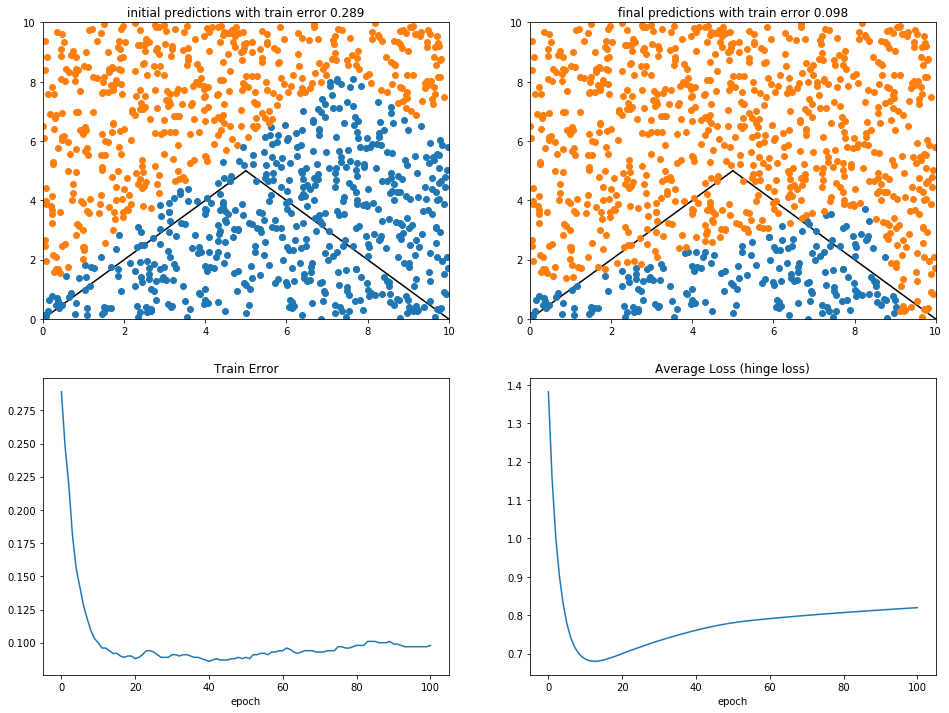

In [28]:
fig, ax = plot_training_info(train_data, data, nn_4)
print("minimum training error:", min([d['train_error'] for d in data]))
plt.show()

This is interesting, Here we see that the training error and hinge loss do 
mirror each other as we would hope. However, it appears that we are 
overshooting the minimum. Let's look at a video evolution of the
training and see what happens.

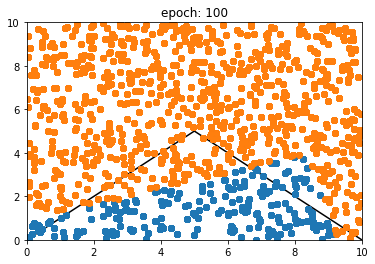

In [29]:
nn_ = NeuralNet([input_layer, hidden_layer, output_layer])

fig, ax = plt.subplots()

ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.plot([0, 5], [0, 5], color='black')
ax.plot([5, 10], [5, 0], color='black')

def init():
    return []

def animate(i):
    nn_.w = data[i]['w']
    s_predict = nn_.predict(train_data[['x_1', 'x_2']])
    c = s_predict == 1
    ax.set_title("epoch: {}".format(i+1))
    animList = ax.plot(train_data[c]['x_1'], train_data[c]['x_2'], 'C0o',
                       train_data[~c]['x_1'], train_data[~c]['x_2'], 'C1o')
    return animList


anim = FuncAnimation(fig, animate, init_func=init,
                     frames=100, interval=100, blit=True)

HTML(anim.to_html5_video())

It looks like it just overshoots, as if `eta` is too large or perhaps the `batch_size` is
too small? 

### Training attempt no. 5 - slower

Let's train the same starting position but cut `eta` in half to slow down
the learning.

minimum training error: 0.085


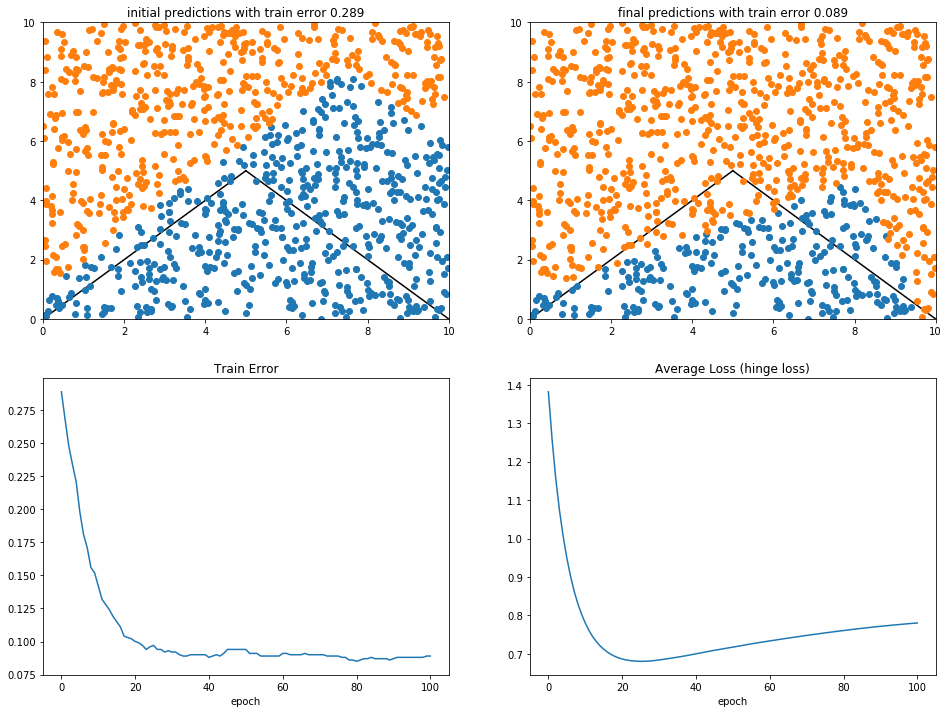

In [30]:
nn_5 = NeuralNet([input_layer, hidden_layer, output_layer])

initial_weights = [
    np.array([[1, -1, 1], [2, 0, -15]])
    ,np.array([[1, -1]])
]
nn_5.w = initial_weights

data = nn_5.fit(train_data[['x_1', 'x_2']], train_data['y'],
              eta=.0005,
              max_error=0.05,
              max_epochs=100,
              batch_size=100,
              save_data=True,
              random_seed=6)


fig, ax = plot_training_info(train_data, data, nn_5)
print("minimum training error:", min([d['train_error'] for d in data]))
plt.show()

I performed more experiments as well. The larger the batch size, the longer this more stable
period endured, but I could still increase the number of epochs until the average loss
and indeed the gradients eventually exploded. It seems like the behavior was basically
the same in all cases, but with a slower learning rate and a larger batch size, the
best possible behavior would lost longer, but not be fundamentally different. Perhaps
rounding errors in calculating the average values used in the weights eventually win out?
I'm honestly not sure how to describe the behavior. Note that we did achieve the same
minimum training error here as we did above.

### Training attempt no. 6 - wider

Finally, let's try something different. Previously we were training from an advantageous 
starting position because the random starting position did not seem to help.
What if we increase the width of this shallow neural net? I'll spare the
many training runs with different random seeds, but I found a very minor 
success with with a width 8 neural network without a constant term. Pretty much
everything blew up, and as you'll see below, nothing particularly good happened
here either.

minimum training error: 0.146


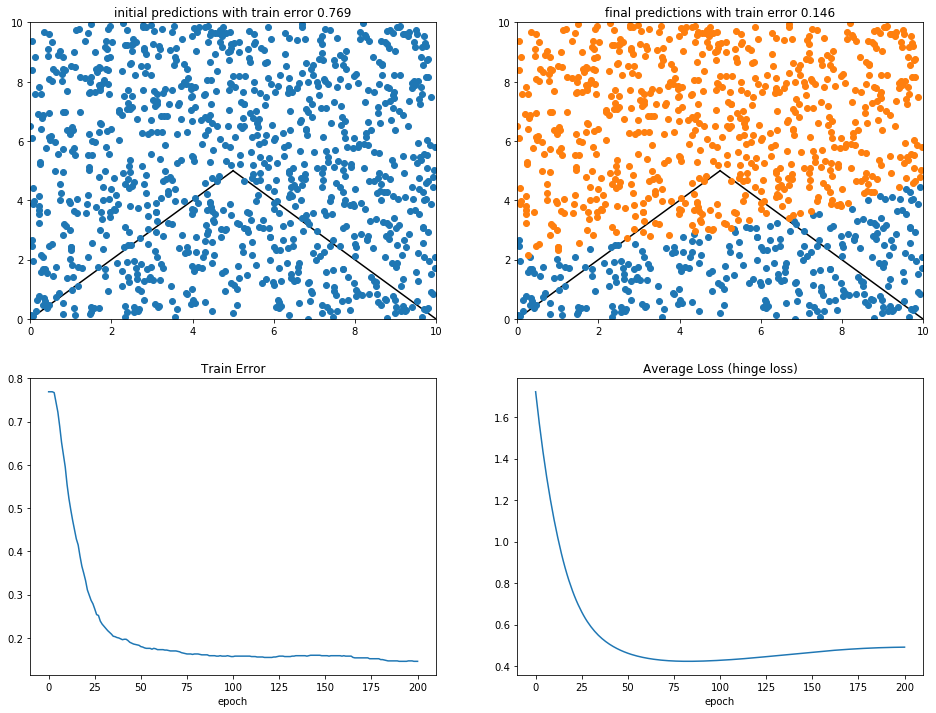

In [31]:
input_layer = Layer(3, lambda x: x, None, True)
hidden_layer = Layer(8, relu, relu_prime, False)
output_layer = Layer(1, lambda x: x, const, False)

nn_6 = NeuralNet([input_layer, hidden_layer, output_layer], random_seed=5)

data = nn_6.fit(train_data[['x_1', 'x_2']], train_data['y'],
              eta=.0005,
              max_error=0.1,
              max_epochs=200,
              batch_size=200,
              save_data=True,
              random_seed=6)

fig, ax = plot_training_info(train_data, data, nn_6)
print("minimum training error:", min([d['train_error'] for d in data]))
plt.show()

### Training 7 - deeper

Finally, I added a couple layers that were decently wide to see if by pure
chance I could get something that worked. Nothing was spectacularly successful,
so I will have to reflect further. Below is a width 8 neural network with
3 hidden layers that did "okay, not great". It is not representative of
my experience, as most things blew up without finding a good regime.
In this sense it seems that intelligent neetwork design and luck are
needed to train well. Given how fertile the field is, more thoughtful
network design must be winning in the end (I'm not that much a skeptic).

minimum training error: 0.113


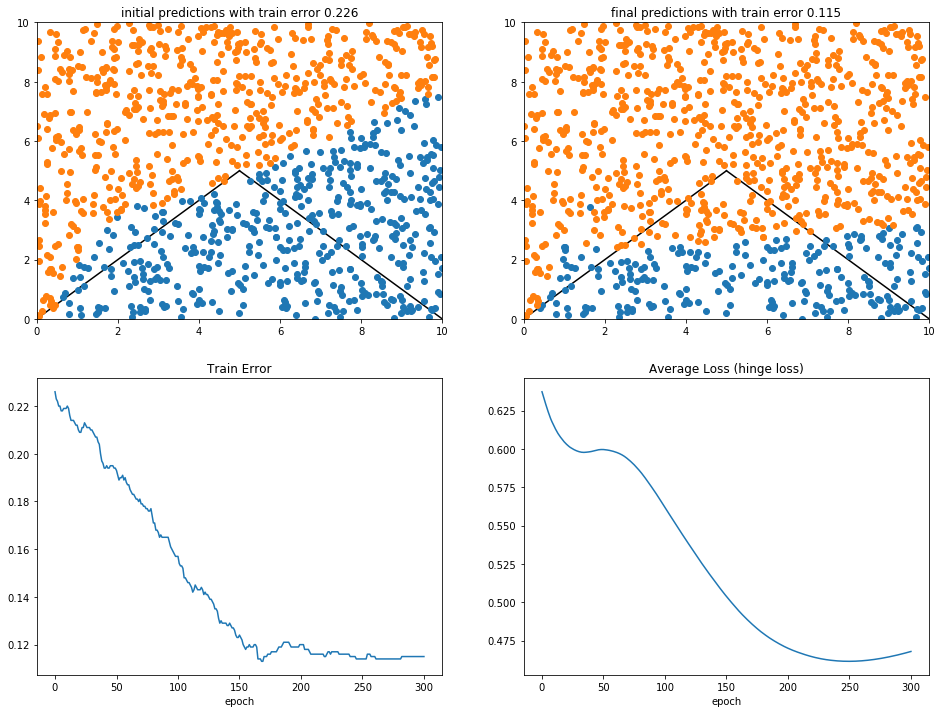

In [35]:
input_layer = Layer(3, lambda x: x, None, True)
hidden_layer_1 = Layer(6, relu, relu_prime, True)
hidden_layer_2 = Layer(8, relu, relu_prime, True)
hidden_layer_3 = Layer(6, relu, relu_prime, True)
output_layer = Layer(1, lambda x: x, const, False)

layers = [
    input_layer
    ,hidden_layer_1
    ,hidden_layer_2
    ,hidden_layer_3
    ,output_layer
]

nn_7 = NeuralNet(layers, random_seed=1)

data = nn_7.fit(train_data[['x_1', 'x_2']], train_data['y'],
              eta=.0005,
              max_error=0.05,
              max_epochs=300,
              batch_size=300,
              save_data=True,
              random_seed=6)

fig, ax = plot_training_info(train_data, data, nn_7)
print("minimum training error:", min([d['train_error'] for d in data]))
plt.show()

## Backpropagation Details

Let's recall the setup. We have a layer $V_t$ of $n_t$ neurons. The
input to $V_t$ is $a_t$ and the output is $o_t = \sigma_t(a_t)$. 
Also, $a_t = W^{t-1}o_{t-1}$, and $W^{t-1}$ is a matrix of size
$n_t\times n_{t-1}$. The activation function $s_t$ will act
componentwise on the $n_t$-dimensional vector $a_t$. $W^0$ is the
weights from the input layer, and $W^T$ is the weights from
the last hidden layer to the output layer, which consists of a single neuron
that has the identity function as its activator.

Let's examine how (the positive part of) the loss $\ell(x, y, W)=1-y f(x, W)$ 
depends on $w^T_k$, a weight from the last hidden layer to the output
layer. We calculate

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^T_k}}
    &= \frac{\partial}{\partial{w^T_k}}(1 - y\sigma_{T+1}'(W^To_T)) \\
    &= -y \sigma_{T+1}'(a_{T+1})o_{T-1, k}.
\end{align*}
$$

We get the $o_{T-1, k}$ term because $a_{T+1}=W^To_T = \sum_i w^T_i o_{T, i}$.
Now let's consider the weight $w^T_{k, n}$ from neuron $n$ in $V_{T-1}$ 
to neuron $k$ in $V_T$. For this partial derivative we first find that

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}}
    &= \frac{\partial}{\partial{w^{T-1}_{k, n}}}(1 - y \sigma_{T+1}(W^T\sigma_T(W^{T-1}o_{T-1}))) \\
    &= -y \sigma_{T+1}'(a_{T+1})\frac{\partial}{\partial{w^{T-1}_{k, n}}} W^T\sigma_T(W^{T-1}o_{T-1})
\end{align*}
$$

Stopping for a moment to consider this, $w^{T-1}_{k, n}$ only feeds neuron $k$ in $V_T$,
so only the $k$th component of $\sigma_T$ is affected. Since the output layer only has one neuron,
the only weight from this neuron is $w^T_k$, so we end up with

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}}
    &= -y \sigma_{T+1}'(a_{T+1}) w^T_k \sigma_{T, k}'(a_T) o_{T-1, n}.
\end{align*}
$$

Note that we've repeated $-y\sigma_{T+1}'(a_{T+1})$. Let's get a little ahead 
of ourselves define

$$
    \delta_{T+1} := -y, \quad
    \delta_{T, k} := \delta_{T+1,k}\sigma_{T+1}'(a_{T+1})w^T_k.
$$

Such that

$$
    \frac{\partial\ell}{\partial{w^T_k}} = \delta_{T+1}\sigma_{T+1}'(a_{T+1})o_{T-1, k},\quad
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}} = \delta_T\sigma_{T, k}'(a_T) o_{T-1, n}.
$$

This already shows how backpropogation might work. A first forward pass through the neural
net is necessary to calculate the $a_i$ and $o_i$, while on the backward pass we
calculate the derivates one layer at a time, from output to input, storing the $\delta$
values along the way to help calculate successive derivatives. However, since the output
layer only has one neuron, it's a little bit cheating to say that we are done, so
let's calculate a derivative with respect to $w^{T-2}_{n, m}$ to get the full scope of
the behavior. What changes here is that while $w^{T-2}_{n, m}$ only feeds neuron $n$
in $V_{T-1}$, but neuron $n$ in $V_{T-1}$ feeds every neuron in $V_T$, of which there are
multiple. So now the calculate looks like

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-2}_{n, m}}}
    &= -y \sigma_{T+1}'(a_{T+1})\sum_{i=1}^{n_T}w^T_i\sigma_{T, i}'(a_T)w^{T-1}_{i, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m} \\
    &= \sum_{i=1}^{n_T}\delta_{T, i}\sigma_{T, i}'(a_T)w^{T-1}_{i, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m}.
\end{align*}
$$

Therefore we define

$$
    \delta_{T-1, n} = \sum_{i=1}^{n_T}\delta_{T, i}\sigma_{T, i}'(a_T)w^{T-1}_{i, n}
$$

such that

$$
    \frac{\partial\ell}{\partial w^{T-2}_{n, m}} = \delta_{T-1, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m}.
$$

What we've shown is that the backward pass can be summarized by

$$
\begin{align*}
    \delta_{T+1} &= -y, \\
    \delta_{t} &= {}^TW^t(\sigma_{t+1}'(a_{t+1})*\delta_{t+1}), \\
    \frac{\partial\ell}{\partial w^t} &= (\sigma_{t+1}'(a_{t+1})*\delta_{t+1})({}^To_t),
\end{align*}
$$

where ${}^TA$ is the transpose of $A$ and $(x*y)$ is the elementwise product. Looking
at the structure of the recursion, it becomes clear what each component is. 
The $\delta_{t+1}$ vectors hold the information for all derivatives beyond (closer to the
output) layer $t+1$. Then $\sigma'_{t+1}$ encodes the derivatives at
layer $t+1$. Since the activation functions at a layer act diagonally (for now), 
you can take the elementwise product, as
you would get a diagonal matrix for the Jacobian of activation functions.
Then, the input $a_{t+1}$ that feeds into layer $t+1$ depends has
the form $W^to_t$. If you want to go another layer down the network before taking
a derivative with respcet to the weights at a lower layer, you have to take the
derivative with respect to $o_t$ and you end up with a $W^t$ term. Since you are
going from a layer that has size $n_{t+1}$ to a layer of size $n_t$ you need
a matrix of sixe $n_t\times n_{t+1}$, which is why you get ${}^TW_t$. 
Similarly, if you are at the layer you want and are taking the derivative with
respect to $W^t$, then you end up with ${}^To_t$ instead.

In other words, we are taking derivatives of the loss due to layer
$t+1$, which we can denote $\ell_{t+1}$ which takes in $\sigma_{t+1}$
which in turn has $W^to_t$ as its input. If we are goign further
down the chain through $\ell_t$ we need a derivative with respect to
$o_t$, if not we take a derivative with respect to $W^t$.
So we have decomposed the loss $\ell$ as $\ell = \ell_{T+1}\circ\ell_T\circ\cdots$
where each step looks like
$
 \ell_{t+1}(\sigma_{t+1}(W^to_t)).
$

The recursive formula also tells us how we would need to edit backpropagation
if we change the form of the neural net. If the mapping between spaces is no
longer linear, than the $o_t$ and $W^t$ terms would change depending on the
function used. If the activation functions were no longer elementwise,
then instead of $\s_{t+1}'$ we would need a full Jacobian matrix.
This procedure also begs the question of what should be done if the 
activation functions are not differentiable / do not have a well-defined
subgradients. Although practically, piece-wise differentiability should
suffice.

Just what sort of generalizations would be useful would be the big question.
Currently, as someone building up intuition from scratch, I'd say that 
the reason we stick with linear mappings and elementwise activators is that
it's hard to understand anything more complex. Putting anything more complicated
in represents a form of prior knowledge of bias. Without that, it should
always be effective -- given a sufficiently long training period -- to 
increase the width and depth, as it seems from our investigations in the
activation functions notebook that this is all we need in order to represent
more complex functions. It has been remarked that all of mathematics is time
spent reducing to linear operations, and this is yet another example of that
phenomenon.